# Extract the data

<font size="4">1)select * from city_level;<br/>2)select city,count(*) from city_list group by city;<br/>3) select *from global_data;</font>

# Open up the CSV


<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [1]:
%pylab
%matplotlib inline
import pandas as pd
import numpy as np

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#..........Load CSV file...........
city_data=pd.read_csv("city_data.csv")
global_data=pd.read_csv("Global_data.csv")
city_list=pd.read_csv("City_list.csv")

<h2>Finding The missing Values</h2>

In [4]:
#................finding missing rows......................
def missing_rows(data):
    i=1
    for col in data.columns:
        res=sum(data[col].isna()) ### isna() gives the bool value of each row if is_null gives True
        if(res>0):
            print(str(i)+" "+col+" has "+str(res)+" Missing values")
        else:
            print(str(i)+" "+col+" has No Missing values")
        i+=1
print("City_data: ")
missing_rows(city_data)
print("City_list: ")
missing_rows(city_list)
print("Global_data: ")
missing_rows(global_data)

City_data: 
1 year has No Missing values
2 city has No Missing values
3 country has No Missing values
4 avg_temp has 2547 Missing values
City_list: 
1 city has No Missing values
2 country has No Missing values
Global_data: 
1 year has No Missing values
2 avg_temp has No Missing values


<h3>Filling Missing Value with there mean Value of the column</h3>

In [5]:
# avg_temp has NaN value which is replaced with the mean value of that column
city_data.avg_temp=city_data.avg_temp.fillna(city_data.avg_temp.mean())

# Moving averages are calculated to be used in the line chart.

<b>Following step is selecting one of the country</b>

In [11]:
cities_data=city_data[city_data.country=="Germany"]
cities_data.city.unique()

array(['Berlin', 'Hamburg', 'Munich'], dtype=object)

<b>In the this step the global_data dataframe and the "Berlin" dataframe will be copied. Also it will be made sure, that both dataframes fit in size (1750 - 2013) in order to compare the data better. In addition the rolling mean will be calculated with a window of 7 years. This should lead to a better readable plot without losing too much information. The last step consists of resetting the index of the "Berlin" dataframe, so that the index of both dataframes also fit and the correlation can be calculated later.</b>

In [12]:
#create a copy of the city_data dataframe and the global_data dataframe for our needs
berlin = city_data[(city_data["city"] == "Berlin") & (city_data["year"] >= 1750)].copy()
global_data_plot = global_data[global_data["year"] < 2014].copy()

In [16]:
#setting the window for the rolling mean
avg_num = 7

#calculate the rolling mean 
berlin["rollingAverage"] = berlin["avg_temp"].rolling(window = avg_num).mean()

#reset the index of the Berlin dataframe
berlin.reset_index(inplace = True, drop = True)

#calculate the rolling mean for the global_data_plot dataframe
global_data_plot["rollingAverage"] = global_data_plot["avg_temp"].rolling(window = avg_num).mean()

In [17]:
berlin[10:20]

,year,city,country,avg_temp,rollingAverage
10,1760,Berlin,Germany,8.99,8.828571
11,1761,Berlin,Germany,9.47,8.968571
12,1762,Berlin,Germany,8.53,9.007143
13,1763,Berlin,Germany,8.62,8.864286
14,1764,Berlin,Germany,8.91,8.830000
15,1765,Berlin,Germany,8.54,8.871429
16,1766,Berlin,Germany,8.87,8.847143
17,1767,Berlin,Germany,8.14,8.725714
18,1768,Berlin,Germany,8.03,8.520000
19,1769,Berlin,Germany,8.46,8.510000


In [19]:
global_data_plot[7:]

,year,avg_temp,rollingAverage
7,1757,9.02,8.121429
8,1758,6.74,7.944286
9,1759,7.99,8.260000
10,1760,7.19,8.088571
11,1761,8.77,8.131429
...,...,...,...
259,2009,9.51,9.535714
260,2010,9.70,9.560000
261,2011,9.52,9.588571
262,2012,9.51,9.561429


<b>In this step includes plotting data in line plot.The Moving average data and raw data is plotted</b>

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C



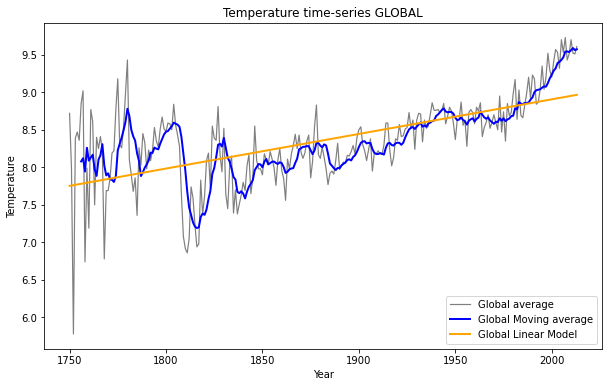

In [96]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
#create a matplotlib figure and axes
fig, ax = plt.subplots(figsize = (10,6))
def global_plot(raw=True):
    clf=LinearRegression()
    clf.fit(global_data_plot[['year']],global_data_plot[['avg_temp']])
    global_data_plot['pred']=clf.predict(global_data_plot[['year']])
    print("Slope of Global data growth :- ",clf.coef_[0][0])
    print(f"Global data info(in degree centegrade): \n\tMin : {global_data_plot.avg_temp.min()} °C \n\tMax : {global_data_plot.avg_temp.max()} °C\n\tAverage : {global_data_plot.avg_temp.mean()} °C\n")
    #plot the global data with a lineplot
    #checking to plot raw avg_temp
    if raw:
        sns.lineplot(x = "year", y = "avg_temp", data = global_data_plot, label = "Global average", alpha =0.5,color = "black", lw = 1.2)
    #plotting Moving Average
    sns.lineplot(x = "year", y = "rollingAverage", data = global_data_plot, label = "Global Moving average", color = "blue", lw = 2)
    #plotting Linear growth
    sns.lineplot(x = "year", y = "pred", data = global_data_plot, label = "Global Linear Model",color = "orange", lw = 2)
global_plot()
#show the plot-labels in the legend
ax.legend()
#set the y label of the plot
ax.set_ylabel("Temperature")
#set the x label of the plot
ax.set_xlabel("Year")
#set the title of the plot
ax.set_title("Temperature time-series GLOBAL")

#show the plot (basically not necessary for jupyter but I always put it at the end)
plt.show()

In [81]:

def compute_df(city,avg_num=7,global_plotting=False,raw=False,city_data=city_data):
    '''Input:
            list of Cities,
            Moving Average
            bool value to add global plotting
        Output
            plot the cities'''
    
    #selecting dataframe for the chosen city and years bigger or equal 1750 and smaller 2014 (for consistency)
    df_city = city_data[(city_data["city"] == city) & (city_data["year"] >= 1750) &(city_data["year"] < 2014)].copy()
    #calculate rolling average with window = avg_num
    df_city["rollingAverage"] = df_city["avg_temp"].rolling(window = avg_num).mean()
    
    # finding the slop of growth of temperatue to the city
    #cretaing Linearregression Model
    clf = LinearRegression()
    #Fitting the data and train
    clf.fit(X = df_city[["year"]], y = df_city[["avg_temp"]])
    #finding the linear growth of temperature of the city 
    df_city['pred'] = clf.predict(df_city[["year"]])
    
    
    #create a matplotlib figure and axes
    fig, ax = plt.subplots(figsize = (10,6))
    
    # check for add global plot
    if global_plotting:
        #it add global plotting in plot
        global_plot(raw)
    
    print(f"Slope of {city} growth :- ",clf.coef_[0][0])
    print(f"{city} data info: \n\tMin : {df_city.avg_temp.min()} °C \n\tMax : {df_city.avg_temp.max()} °C\n\tAverage : {df_city.avg_temp.mean()} °C\n")
    
    
    if raw:
        #ploting raw data
        sns.lineplot(x = "year", y = "avg_temp", data = df_city, label = city+" average", alpha = 0.5,color = "grey", lw = 1.2)
    #plotting the moving average of the data
    sns.lineplot(x = "year", y = "rollingAverage", data = df_city, label = city+" Moving average",color = "steelblue", lw = 2)
    #plotting the linear up/down growth of the data
    sns.lineplot(x = "year", y = "pred", data = df_city, label = city+" Linear Growth",color = "red", lw = 2)
    
    #show the plot-labels in the legend
    ax.legend()
    #set the y label of the plot
    ax.set_ylabel("Temperature")
    #set the x label of the plot
    ax.set_xlabel("Year")
    #set the title of the plot
    ax.set_title("Temperature time-series "+city)
    
    

    #show the plot (basically not necessary for jupyter but I always put it at the end)
    plt.show()


<b>Positive slope result that temperature Increases <br/>
com</b>

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Berlin growth :-  0.003784711307058678
Berlin data info(in degree centegrade): 
	Min : 4.84 
	Max : 10.96
	Average : 8.917727272727273



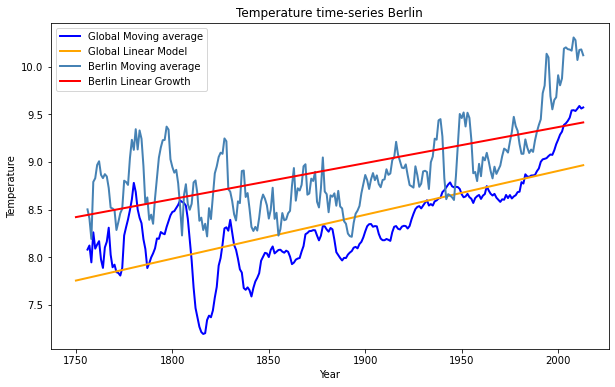

In [86]:
compute_df("Berlin",7,global_plotting=True)

<b>Plotting city with avg_temp and global_data</b>

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Berlin growth :-  0.003784711307058678
Berlin data info(in degree centegrade): 
	Min : 4.84 
	Max : 10.96
	Average : 8.917727272727273



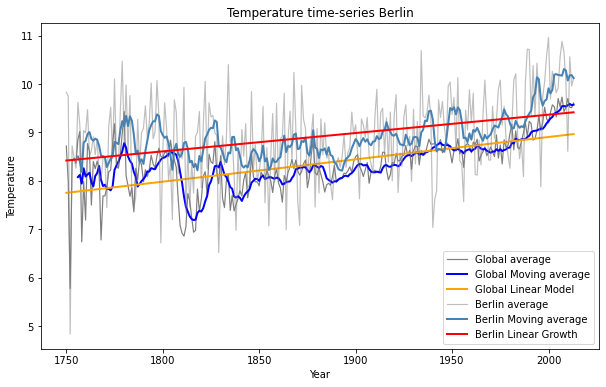

In [88]:
compute_df("Berlin",7,True,True)

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Prague growth :-  0.0036796105107318256
Prague data info(in degree centegrade): 
	Min : 3.94 
	Max : 10.3
	Average : 8.23492424242424



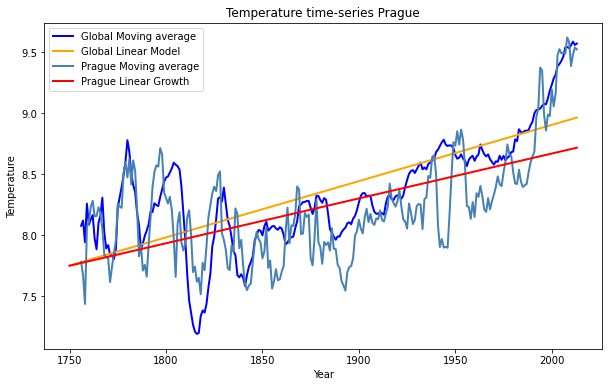

In [89]:
compute_df("Prague",7,True)

<p style='color="red"'><b> New York city has higest slope this indicate the growth of temperature is higher then other cities and also higher then global growth rate</b></p>

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of New York growth :-  0.006471784322246059
New York data info(in degree centegrade): 
	Min : 0.25 
	Max : 16.13884548318558
	Average : 9.512078960163581



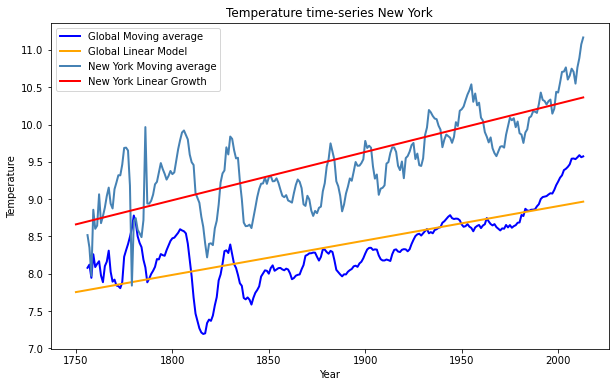

In [90]:
compute_df("New York",7,True)

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Abu Dhabi growth :-  0.03033804242693761
Abu Dhabi data info(in degree centegrade): 
	Min : 16.13884548318558 
	Max : 28.69
	Average : 25.83752132045747



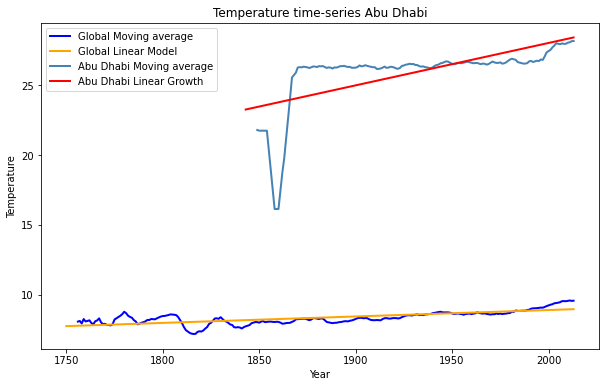

In [91]:
compute_df("Abu Dhabi",7,True)

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Ahmadabad growth :-  0.01456502324367299
Ahmadabad data info(in degree centegrade): 
	Min : 16.13884548318558 
	Max : 28.1
	Average : 25.958835531184526



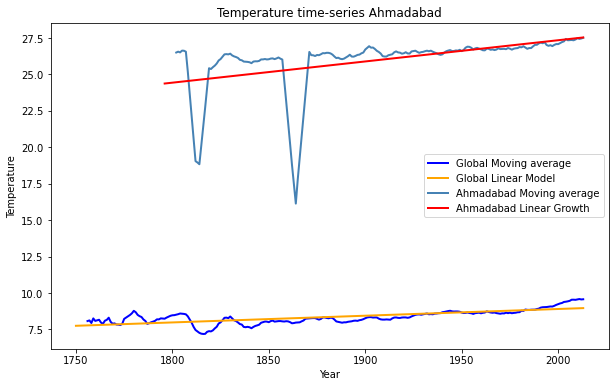

In [92]:
compute_df("Ahmadabad",7,True)

Slope of Global data growth :-  0.004611110748782029
Global data info(in degree centegrade): 
	Min : 5.78 °C 
	Max : 9.73 °C
	Average : 8.35939393939394 °C

Slope of Hamburg growth :-  0.0038571992251954937
Hamburg data info(in degree centegrade): 
	Min : 4.65 
	Max : 10.37
	Average : 8.328901515151516



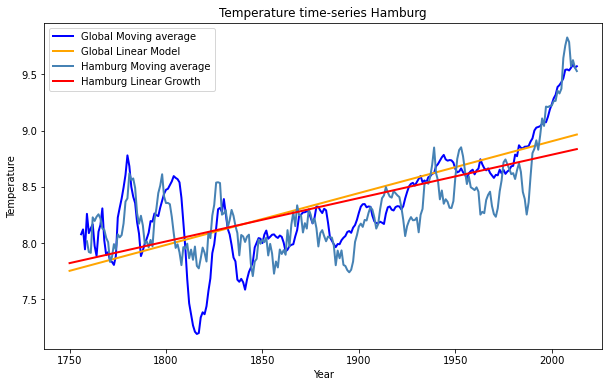

In [94]:
compute_df("Hamburg",10,True)

# Conclusion 

<b>To conclude, there is a clear overall uptrend visible, what means, that the average global temperature is increasing, with an also increasing tempo.</b>

<b> In these Cites Berlin,Prague,New York,Abu Dhabi,Ahmadabad,Hamburg<br/>
    1)the slope of the global trend is higher than compared to the most cities, so the global average temperature is               increasing faster (looking at this long time period)<br/>
    2)New York has higher slope then other cities and also global this indicate Temperature is growing higher the other countries as it was Fast growing city in world<br/>
3)Ahmadabad and Abu Dhabi  has highest minimum and maximum temprature then other cities and global data.This tell that Ahmadabad is a hot place<br/>
4)Temperature's of Hamburg and Prague has nearly same as global average temperature levels<br/>
</b>